In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# scaled the data
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds


## **Learning Rate Scheduling**

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [2]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)


In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [4]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4925 - accuracy: 0.8264 - val_loss: 0.4165 - val_accuracy: 0.8576
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3828 - accuracy: 0.8647 - val_loss: 0.3774 - val_accuracy: 0.8668
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3496 - accuracy: 0.8759 - val_loss: 0.3602 - val_accuracy: 0.8740
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3277 - accuracy: 0.8829 - val_loss: 0.3552 - val_accuracy: 0.8750
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3124 - accuracy: 0.8895 - val_loss: 0.3448 - val_accuracy: 0.8790
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2993 - accuracy: 0.8936 - val_loss: 0.3446 - val_accuracy: 0.8784
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2884 - accuracy: 0.8972 - val_loss: 0.3408 - val_accuracy:

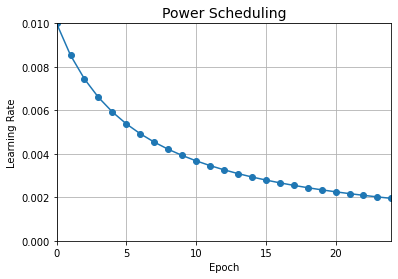

In [5]:
import math
import matplotlib.pyplot as plt

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)

# realmente el por cada epoch se realizan n_steps_per_epoch iteraciones
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()


### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [6]:
def exponential_decay(lr0, s):
    """create a function that returns a configured function that
        implementing Exponential Scheduling:
    """
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn


In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25


In [8]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])


Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8249 - accuracy: 0.7623 - val_loss: 0.7162 - val_accuracy: 0.8038 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7729 - accuracy: 0.7791 - val_loss: 1.0845 - val_accuracy: 0.7390 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7412 - accuracy: 0.7861 - val_loss: 0.5900 - val_accuracy: 0.8200 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6221 - accuracy: 0.8187 - val_loss: 0.5689 - val_accuracy: 0.8250 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5606 - accuracy: 0.8375 - val_loss: 0.5667 - val_accuracy: 0.8250 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4720 - accuracy: 0.8488 - val_loss: 0.5821 - val_accuracy: 0.8456 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 9

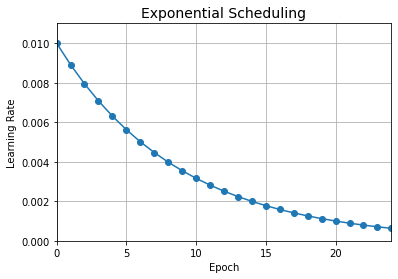

In [9]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()


`LearningRateScheduler` actualizará el atributo *learning_rate* del
optimizador al principio de cada época. Actualizar la tasa de aprendizaje
una vez por época suele ser suficiente, pero si quieres que se actualice
más a menudo, por ejemplo en cada paso, siempre puedes escribir tu
propia `callbacks`

In [10]:
K = keras.backend


class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32  # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])


Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7952 - accuracy: 0.7660 - val_loss: 0.7221 - val_accuracy: 0.7672 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6540 - accuracy: 0.8023 - val_loss: 0.8136 - val_accuracy: 0.7208 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5569 - accuracy: 0.8263 - val_loss: 0.5787 - val_accuracy: 0.8440 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5056 - accuracy: 0.8421 - val_loss: 0.5053 - val_accuracy: 0.8508 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4596 - accuracy: 0.8510 - val_loss: 0.5230 - val_accuracy: 0.8568 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4278 - accuracy: 0.8635 - val_loss: 0.4598 - val_accuracy: 0.8642 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

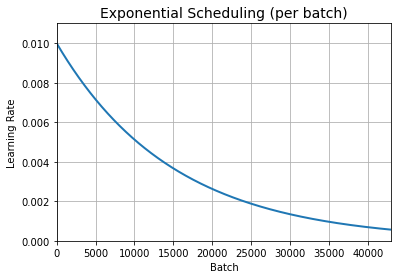

In [11]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()


### Piecewise Constant Scheduling

In [12]:
# Ejemplo de una funcion no dinamica
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001


def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn


In [13]:
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])


Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8638 - accuracy: 0.7532 - val_loss: 0.9660 - val_accuracy: 0.7418 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8781 - accuracy: 0.7504 - val_loss: 0.9460 - val_accuracy: 0.7362 - lr: 0.0100
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9884 - accuracy: 0.7081 - val_loss: 1.0710 - val_accuracy: 0.6514 - lr: 0.0100
Epoch 4/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9913 - accuracy: 0.6568 - val_loss: 1.1162 - val_accuracy: 0.6286 - lr: 0.0100
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0741 - accuracy: 0.6347 - val_loss: 1.1151 - val_accuracy: 0.6064 - lr: 0.0100
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8339 - accuracy: 0.6820 - val_loss: 0.9686 - val_accuracy: 0.6948 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 8s

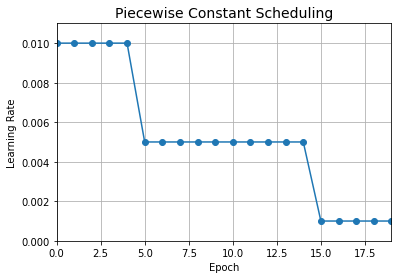

In [14]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)


### Performance Scheduling

Para programar el rendimiento, utilice `ReduceLROnPlateau callbacks`. Por ejemplo, si pasa 
la siguiente callbacks al método fit(), multiplicará la tasa de aprendizaje por 0,5
siempre que la mejor pérdida de validación no mejore durante cinco
épocas consecutivas (hay otras opciones disponibles; consulte la
documentación para obtener más detalles)

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])


Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5937 - accuracy: 0.8053 - val_loss: 0.4665 - val_accuracy: 0.8482 - lr: 0.0200
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5034 - accuracy: 0.8381 - val_loss: 0.5676 - val_accuracy: 0.8360 - lr: 0.0200
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5189 - accuracy: 0.8411 - val_loss: 0.5369 - val_accuracy: 0.8588 - lr: 0.0200
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5264 - accuracy: 0.8437 - val_loss: 0.5351 - val_accuracy: 0.8512 - lr: 0.0200
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5109 - accuracy: 0.8503 - val_loss: 0.5020 - val_accuracy: 0.8410 - lr: 0.0200
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4969 - accuracy: 0.8543 - val_loss: 0.5400 - val_accuracy: 0.8424 - lr: 0.0200
Epoch 7/20
1719/1719 [==============================] - 5s

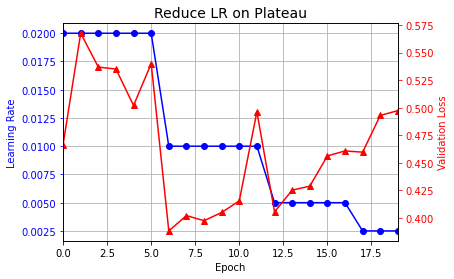

In [16]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


### tf.keras schedulers
tf.keras ofrece una forma alternativa de implementar la
programación de la tasa de aprendizaje: definir la tasa de aprendizaje
utilizando una de las programaciones disponibles en
`keras.optimizers.schedules`, y luego pasar esta tasa de aprendizaje a
cualquier optimizador
Esto es agradable y simple, además cuando guardas el modelo, la tasa
de aprendizaje y su programación (incluyendo su estado) se guardan
también. Este enfoque, sin embargo, *no es parte de la API de Keras*; es
específico de **tf.keras**.


In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32  # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4875 - accuracy: 0.8284 - val_loss: 0.4042 - val_accuracy: 0.8624
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3771 - accuracy: 0.8673 - val_loss: 0.3686 - val_accuracy: 0.8718
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3432 - accuracy: 0.8796 - val_loss: 0.3700 - val_accuracy: 0.8688
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3217 - accuracy: 0.8859 - val_loss: 0.3459 - val_accuracy: 0.8792
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3062 - accuracy: 0.8917 - val_loss: 0.3381 - val_accuracy: 0.8790
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2922 - accuracy: 0.8961 - val_loss: 0.3385 - val_accuracy: 0.8840
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2820 - accuracy: 0.9002 - val_loss: 0.3347 - val_accuracy:

For piecewise constant scheduling, try this:

In [19]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])


### 1Cycle scheduling(no la revise)

El cuanto al enfoque de 1 ciclo, la implementación no plantea ninguna
dificultad particular: basta con crear una callbacks
personalizada que modifique la tasa de aprendizaje en cada iteración
(puede actualizar la tasa de aprendizaje del optimizador cambiando
*self.model.optimizer.lr* )

In [ ]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")


**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3120


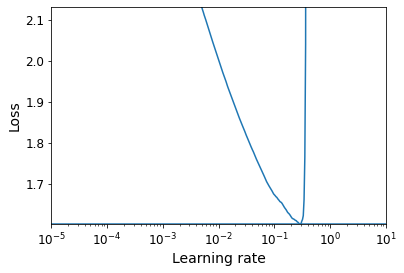

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)


In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)


In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])


Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8397 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4116 - val_accuracy: 0.8588
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3868 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8719 - val_loss: 0.3766 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8775 - val_loss: 0.3739 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3635 - val_accuracy: 0.8708
Epoch 

## **Avoiding Overfitting Through Regularization**

### $\ell_1$ and $\ell_2$ regularization

In [20]:
from keras.regularizers import l2
from keras.layers import Flatten, Dense 

layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively


Generalmente queremos aplicar la misma regularizacion y la  misma funcion de activacion a las misma Hidden Layers podemos usar la funcion `partial()` para no tener q escribir los mismo varias veces. 

In [21]:
from functools import partial

RegularizedDense = partial(Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# history = model.fit(X_train_scaled, y_train, epochs=2,validation_data=(X_valid_scaled, y_valid))


### Dropout

In [39]:
from keras.layers import Dropout
model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    Dropout(rate=0.2),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dropout(rate=0.2),
    Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 5
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5725 - accuracy: 0.8020 - val_loss: 0.3723 - val_accuracy: 0.8618
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4181 - accuracy: 0.8475 - val_loss: 0.3419 - val_accuracy: 0.8756
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3876 - accuracy: 0.8561 - val_loss: 0.3403 - val_accuracy: 0.8746
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3682 - accuracy: 0.8629 - val_loss: 0.3166 - val_accuracy: 0.8846
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3599 - accuracy: 0.8661 - val_loss: 0.2975 - val_accuracy: 0.8894


Dado que el `dropout` sólo está activo durante el train, comparar la pérdida de entrenamiento y la pérdida de validación puede inducir a error. En particular, un modelo puede estar overfitting the traning set y, sin embargo, tener pérdidas de entrenamiento y validación similares. Por tanto, asegúrese de
evaluar la pérdida de entrenamiento sin abandono (por ejemplo, después del entrenamiento).

In [40]:
model.evaluate(X_train_scaled,y_train)


1719/1719 [==============================] - 3s 2ms/step - loss: 0.2638 - accuracy: 0.8991


[0.2637776732444763, 0.8990545272827148]

### Alpha Dropout

In [41]:

from keras.backend import clear_session
from keras.layers import AlphaDropout
clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    Flatten(input_shape=[28, 28]),
    AlphaDropout(rate=0.2),
    Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 15
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/15
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6671 - accuracy: 0.7579 - val_loss: 0.5547 - val_accuracy: 0.8436
Epoch 2/15
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5593 - accuracy: 0.7941 - val_loss: 0.5460 - val_accuracy: 0.8432
Epoch 3/15
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5265 - accuracy: 0.8039 - val_loss: 0.5202 - val_accuracy: 0.8492
Epoch 4/15
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5050 - accuracy: 0.8129 - val_loss: 0.4581 - val_accuracy: 0.8656
Epoch 5/15
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4902 - accuracy: 0.8175 - val_loss: 0.4673 - val_accuracy: 0.8630
Epoch 6/15
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4795 - accuracy: 0.8228 - val_loss: 0.4867 - val_accuracy: 0.8602
Epoch 7/15
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4693 - accuracy: 0.8252 - val_loss: 0.4947 - val_accuracy:

In [42]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4751 - accuracy: 0.8592


[0.4750571846961975, 0.8592000007629395]

In [43]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3720 - accuracy: 0.8774


[0.371981680393219, 0.8774363398551941]

### MC Dropout

Implementación completa de` MC Dropout` ,
potenciando el `Dropput model`*(modelos q tiene una capa Dropout despues de cada Hidden Layer)*  que entrenamos anteriormente sin reentrenarlo: sólo tenemos que hacer 100 predicciones sobre el conjunto de prueba,estableciendo **training=True** para asegurarnos de que la capa Dropout está
activa, y apilar(stack) las predicciones. 

In [54]:
y_probas = np.stack([model(X_test_scaled, training=True) for _ in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


Como hay 10.000 instancias en el conjunto de prueba y 10 clases, se trata
de una matriz de forma [10000, 10]. Apilamos 100 matrices de este tipo,
por lo que y_probas es una matriz de forma [100, 10000, 10].
 
Una vez quepromediamos sobre la primera dimensión (axis=0), obtenemos y_proba, una
matriz de forma [10000, 10]

In [55]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 24ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [56]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.09, 0.  , 0.84]],
      dtype=float32)

El promedio de varias predicciones con el **Dropout = True** nos da una estimación de Monte Carlo que suele ser más fiable que el resultado de una sola predicción con **Dropout = False**. El modelo sigue pensando que esta imagen pertenece a la clase 9, pero sólo con un 84% de confianza, lo que parece mucho más razonable que un 99%. Además, es útil saber exactamente qué otras clases considera
probables.

> ahora veamos la accuracy del modelo 

In [57]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8635

Si su modelo contiene otras capas que se comportan de manera
especial durante el entrenamiento (como las capas **BatchNormalization**),
entonces no debe forzar el modo de entrenamiento como acabamos de
hacer. En su lugar, debe sustituir las capas Dropout por la siguiente

In [58]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Para cambiar de un modelo a nuestro modelos con MCDropout Layer

In [61]:
tf.random.set_seed(42)
np.random.seed(42)
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

mc_model.set_weights(model.get_weights())


Now we can use the model with MC Dropout:

In [62]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 35ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.11, 0.  , 0.79]],
      dtype=float32)

## Max norm

In [63]:
layer = Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [64]:

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4749 - accuracy: 0.8339 - val_loss: 0.3716 - val_accuracy: 0.8658
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3525 - accuracy: 0.8714 - val_loss: 0.3690 - val_accuracy: 0.8664


Si desea utilizar maxnorm con **capas convolucionales** (véase el capítulo 14),
asegúrese de establecer el argumento eje de la restricción max_norm()
adecuada  (usually axis=[0,1,2])